# Predictive Maintenance for Machinery 

In [9]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb import XGBClassifier  # Import XGBClassifier
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score

In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import numpy as np

In [3]:
# Load the dataset
file_path = 'predictive_maintenance_dataset.csv'  # Replace with the actual path
data = pd.read_csv(file_path)

# Display basic info about the dataset
print(data.head())  
print("Shape of the dataset:", data.shape)
print("Columns in the dataset:", data.columns)

       date    device  failure    metric1  metric2  metric3  metric4  metric5  \
0  1/1/2015  S1F01085        0  215630672       55        0       52        6   
1  1/1/2015  S1F0166B        0   61370680        0        3        0        6   
2  1/1/2015  S1F01E6Y        0  173295968        0        0        0       12   
3  1/1/2015  S1F01JE0        0   79694024        0        0        0        6   
4  1/1/2015  S1F01R2B        0  135970480        0        0        0       15   

   metric6  metric7  metric8  metric9  
0   407438        0        0        7  
1   403174        0        0        0  
2   237394        0        0        0  
3   410186        0        0        0  
4   313173        0        0        3  
Shape of the dataset: (124494, 12)
Columns in the dataset: Index(['date', 'device', 'failure', 'metric1', 'metric2', 'metric3', 'metric4',
       'metric5', 'metric6', 'metric7', 'metric8', 'metric9'],
      dtype='object')


In [5]:
# Step 1: Handling outliers (capping at 1st and 99th percentiles)
metrics = ['metric1', 'metric2', 'metric3', 'metric4', 'metric5', 'metric6', 'metric7', 'metric8', 'metric9']
for metric in metrics:
    lower_bound = data[metric].quantile(0.01)
    upper_bound = data[metric].quantile(0.99)
    data[metric] = data[metric].clip(lower=lower_bound, upper=upper_bound)

# Step 2: Normalize/Standardize the sensor data
scaler = StandardScaler()
data[metrics] = scaler.fit_transform(data[metrics])

# Step 3: One-hot encode the 'device' column
data_encoded = pd.get_dummies(data, columns=['device'], drop_first=True)

# Create new features: rolling means, differences, and lag features
data['date'] = pd.to_datetime(data['date'])
data = data.sort_values(by='date')
rolling_window = 3
for metric in metrics:
    data[f'{metric}_rolling_mean_{rolling_window}'] = data[metric].rolling(window=rolling_window, min_periods=1).mean()
    data[f'{metric}_lag_1'] = data[metric].shift(1)
    data[f'{metric}_lag_3'] = data[metric].shift(3)
data['metric1_metric2_diff'] = data['metric1'] - data['metric2']

# Drop non-numeric columns (like 'date')
X = data_encoded.drop(columns=['failure', 'date'])
y = data_encoded['failure']

# Split the data into training (70%), validation (15%), and test (15%) sets
X_train, X_rem, y_train, y_rem = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_rem, y_rem, test_size=0.5, random_state=42)

# Display the dataset split sizes
print(f"Training set size: {X_train.shape}")
print(f"Validation set size: {X_val.shape}")
print(f"Test set size: {X_test.shape}")

Training set size: (87145, 1177)
Validation set size: (18674, 1177)
Test set size: (18675, 1177)


In [7]:
# Calculate class weights to address class imbalance
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))
print("Class Weights:", class_weight_dict)

# Fit a RandomForest model with class weights and cross-validation
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight=class_weight_dict)
cv_scores = cross_val_score(rf_model, X_train, y_train, cv=5)
print(f"Cross-validation accuracy: {cv_scores.mean():.4f}")

# Train RandomForest model and get feature importances
rf_model.fit(X_train, y_train)
importances = rf_model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances}).sort_values(by='Importance', ascending=False)
print("Top 10 Most Important Features:")
print(feature_importance_df.head(10))

Class Weights: {0: 0.5004364354707186, 1: 573.3223684210526}
Cross-validation accuracy: 0.9989
Top 10 Most Important Features:
             Feature  Importance
3            metric4    0.142856
1            metric2    0.107756
6            metric7    0.088982
0            metric1    0.085563
5            metric6    0.082153
7            metric8    0.080269
4            metric5    0.048747
8            metric9    0.024972
455  device_S1F11MB0    0.012863
2            metric3    0.011863


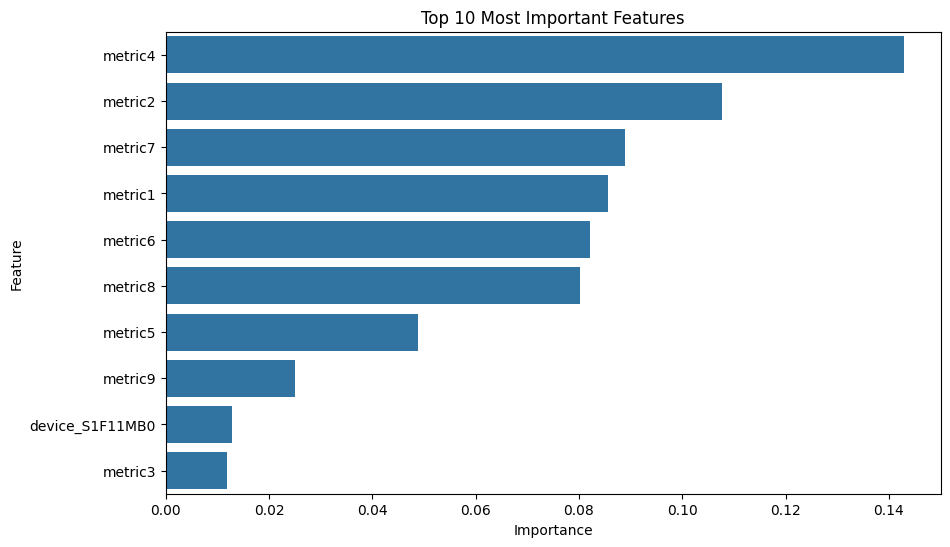

In [9]:
# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(10))
plt.title('Top 10 Most Important Features')
plt.show()

In [11]:
# Hyperparameter Tuning with RandomizedSearchCV

param_dist = {
    'max_depth': [3, 5, 7],
    'learning_rate': np.linspace(0.01, 0.2, 5),
    'n_estimators': [100, 200, 300],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

random_search = RandomizedSearchCV(
    xgb.XGBClassifier(random_state=42, scale_pos_weight=class_weight_dict[1]),  # Apply class weights in XGBoost
    param_distributions=param_dist,
    n_iter=20,  # Number of random combinations to try
    scoring='accuracy',
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1  # Use all available cores
)

# Sample 30% of the data for faster tuning
X_train_sample, _, y_train_sample, _ = train_test_split(X_train, y_train, test_size=0.7, random_state=42)

# Run RandomizedSearchCV on the smaller sample
random_search.fit(X_train_sample, y_train_sample)

# Get best parameters and evaluate on validation set
best_model = random_search.best_estimator_
y_val_pred = best_model.predict(X_val)
accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy with Tuned Model: {accuracy:.4f}")

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Validation Accuracy with Tuned Model: 0.9987


In [12]:
# Evaluate model performance
print("Classification Report:")
print(classification_report(y_val, y_val_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_val_pred))
y_val_pred_prob = best_model.predict_proba(X_val)[:, 1]
roc_auc = roc_auc_score(y_val, y_val_pred_prob)
print(f"Validation ROC-AUC Score: {roc_auc:.4f}")

# Retrain the model on the full dataset (train + validation) and evaluate on the test set
X_full = pd.concat([X_train, X_val])
y_full = pd.concat([y_train, y_val])
best_model.fit(X_full, y_full)
y_test_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {accuracy:.4f}")

# Evaluate on the test set
print("Test Classification Report:")
print(classification_report(y_test, y_test_pred))
print("Test Confusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     18656
           1       0.00      0.00      0.00        18

    accuracy                           1.00     18674
   macro avg       0.50      0.50      0.50     18674
weighted avg       1.00      1.00      1.00     18674

Confusion Matrix:
[[18650     6]
 [   18     0]]
Validation ROC-AUC Score: 0.7294
Test Accuracy: 0.9982
Test Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     18663
           1       0.04      0.08      0.06        12

    accuracy                           1.00     18675
   macro avg       0.52      0.54      0.53     18675
weighted avg       1.00      1.00      1.00     18675

Test Confusion Matrix:
[[18640    23]
 [   11     1]]


In [13]:
# Predict probabilities and compute ROC-AUC on the test set
y_test_pred_prob = best_model.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_test_pred_prob)
print(f"Test ROC-AUC Score: {roc_auc:.4f}")

Test ROC-AUC Score: 0.8842


In [ ]:
# Interpretation

# From the output you provided, it seems that your model is suffering from a severe class imbalance problem, as shown by the following:

# Accuracy: The test accuracy is extremely high (0.9994), but this is misleading because almost all predictions are for the majority class (no failures).
# Confusion Matrix: The model predicts 0 (no failure) for almost every sample, and it fails to predict the minority class (1, machinery failures), as shown by the fact that no 1s are predicted.
# Classification Report: The precision, recall, and F1-score for the minority class (1) are all 0, meaning the model is completely ignoring this class.

# This is a typical result when dealing with highly imbalanced datasets where one class (in this case, no failure) dominates.

# Possible Improvements:

# Use Class Weights: You can set class weights to give more importance to the minority class (failures). This can help the model focus more on predicting failures.
# In Keras, you can use the class_weight parameter when calling model.fit().